In [1]:
import math
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
def get_name_by_path(path):
    return path.split("/")[-1].rsplit('.', 1)[0]

def platform_sort_key(item):
    return platform_order.index(get_name_by_path(item[0]))

def algo_sort_key(item):
    return algo_order.index(item['algorithm']['name'])

def algo_item_sort_key(item):
    return algo_order.index(item[0])

def humanize_workflow_name(wf_name):
    return wf_name.split('_')[0]

platform_order = [
    'platform_rack_4', 'platform_rack_8', 'platform_rack_16',
    'platform_cluster_2', 'platform_cluster_4', 'platform_cluster_8',
    'simple_4',
]
platform_names = {
    'simple_4': '4 ядра x 4 хоста, полносвязный',
    'platform_rack_4': '4 ядра x 4 хоста x 1 стойка',
    'platform_rack_8': '2 ядра x 8 хостов x 1 стойка',
    'platform_cluster_2': '4 ядра x 2 хоста x 2 стойки',
    'platform_cluster_4': '2 ядра x 4 хоста x 2 стойки',
}
algo_order = [
    'BatchMin', 'BatchMax', 'BatchSuff',
    'EBMin', 'EBMax', 'EBSuff',
]
algo_colors = {
    'BatchMin': '#5975A4',
    'BatchMax': '#CC8963',
    'BatchSuff': '#5F9E6E',
    'EBMin': '#B55D60',
    'EBMax': '#857AAB',
    'EBSuff': '#8D7866',
}

In [3]:
import json
import pandas as pd
results = json.load(open('output'))
for x in results:
    x['tasks'] = get_name_by_path(x['tasks'])
    x['platform'] = get_name_by_path(x['platform'])

baseline = {}
expected_baseline = {}
for r in results:
    if r['algorithm']['name'] == 'BatchMin':
        baseline[(r['platform'], r['tasks'])] = r['makespan']
        expected_baseline[(r['platform'], r['tasks'])] = r['expected_makespan']

by_platform_and_algorithm = {}
for r in results:
    by_platform_and_algorithm.setdefault(r['platform'], {})
    by_platform_and_algorithm[r['platform']].setdefault(r['algorithm']['name'], [])
    by_platform_and_algorithm[r['platform']][r['algorithm']['name']].append(r)

def draw_boxplots(show_expected):
    plt.figure(figsize=(16, 20))
    for i, (platform, p_results) in enumerate(sorted(by_platform_and_algorithm.items(), key=platform_sort_key)):
        res = []
        res_type = []
        algorithms = []
        for algorithm, a_results in p_results.items():
            algorithms += [algorithm]*len(a_results)
            if show_expected:
                algorithms += [algorithm]*len(a_results)
                res += [x['expected_makespan']/baseline[(platform, x['tasks'])]*100 for x in a_results]
                res_type += ['Оценка' for x in a_results]
            res += [x['makespan']/baseline[(platform, x['tasks'])]*100 for x in a_results]
            res_type += ['Реальность' for x in a_results]
        data = pd.DataFrame.from_dict({'results': res, 'algorithms': algorithms, 'Тип': res_type})
        plt.subplot((len(by_platform_and_algorithm)+1)//2, 2, i+1)
        if show_expected:
            sns.boxplot(data=data, x='algorithms', y='results', fliersize=0, order=algo_order, hue='Тип')
        else:
            sns.boxplot(data=data, x='algorithms', y='results', fliersize=0, order=algo_order)
            sns.swarmplot(data=data, x='algorithms', y='results', color=".25", order=algo_order)
        plt.ylim(bottom=0)
        plt.xlabel('')
        plt.ylabel('Время работы, %')
        plt.title(f'{platform_names[platform]}', fontsize=18)

In [4]:
def compute_percentage():
    by_platform = {}
    for i, (platform, p_results) in enumerate(sorted(by_platform_and_algorithm.items(), key=platform_sort_key)):
        by_platform[platform] = {}
        res = []
        res_type = []
        algorithms = []
        for algorithm, a_results in p_results.items():
            tmp = [x['makespan']/baseline[(platform, x['tasks'])]*100 for x in a_results]
            by_platform[platform][algorithm] = round(sum(tmp) / len(tmp), 1)
            print(f'platform={platform_names[platform]}, algo={algorithm}, results={by_platform[platform][algorithm]}%')
compute_percentage()

platform=4 ядра x 4 хоста x 1 стойка, algo=BatchMin, results=100.0%
platform=4 ядра x 4 хоста x 1 стойка, algo=BatchMax, results=112.1%
platform=4 ядра x 4 хоста x 1 стойка, algo=BatchSuff, results=111.3%
platform=4 ядра x 4 хоста x 1 стойка, algo=EBMin, results=91.2%
platform=4 ядра x 4 хоста x 1 стойка, algo=EBMax, results=83.4%
platform=4 ядра x 4 хоста x 1 стойка, algo=EBSuff, results=91.9%
platform=2 ядра x 8 хостов x 1 стойка, algo=BatchMin, results=100.0%
platform=2 ядра x 8 хостов x 1 стойка, algo=BatchMax, results=109.9%
platform=2 ядра x 8 хостов x 1 стойка, algo=BatchSuff, results=97.5%
platform=2 ядра x 8 хостов x 1 стойка, algo=EBMax, results=93.0%
platform=2 ядра x 8 хостов x 1 стойка, algo=EBMin, results=91.5%
platform=2 ядра x 8 хостов x 1 стойка, algo=EBSuff, results=88.8%
platform=4 ядра x 2 хоста x 2 стойки, algo=BatchMax, results=117.9%
platform=4 ядра x 2 хоста x 2 стойки, algo=BatchMin, results=100.0%
platform=4 ядра x 2 хоста x 2 стойки, algo=BatchSuff, results=1

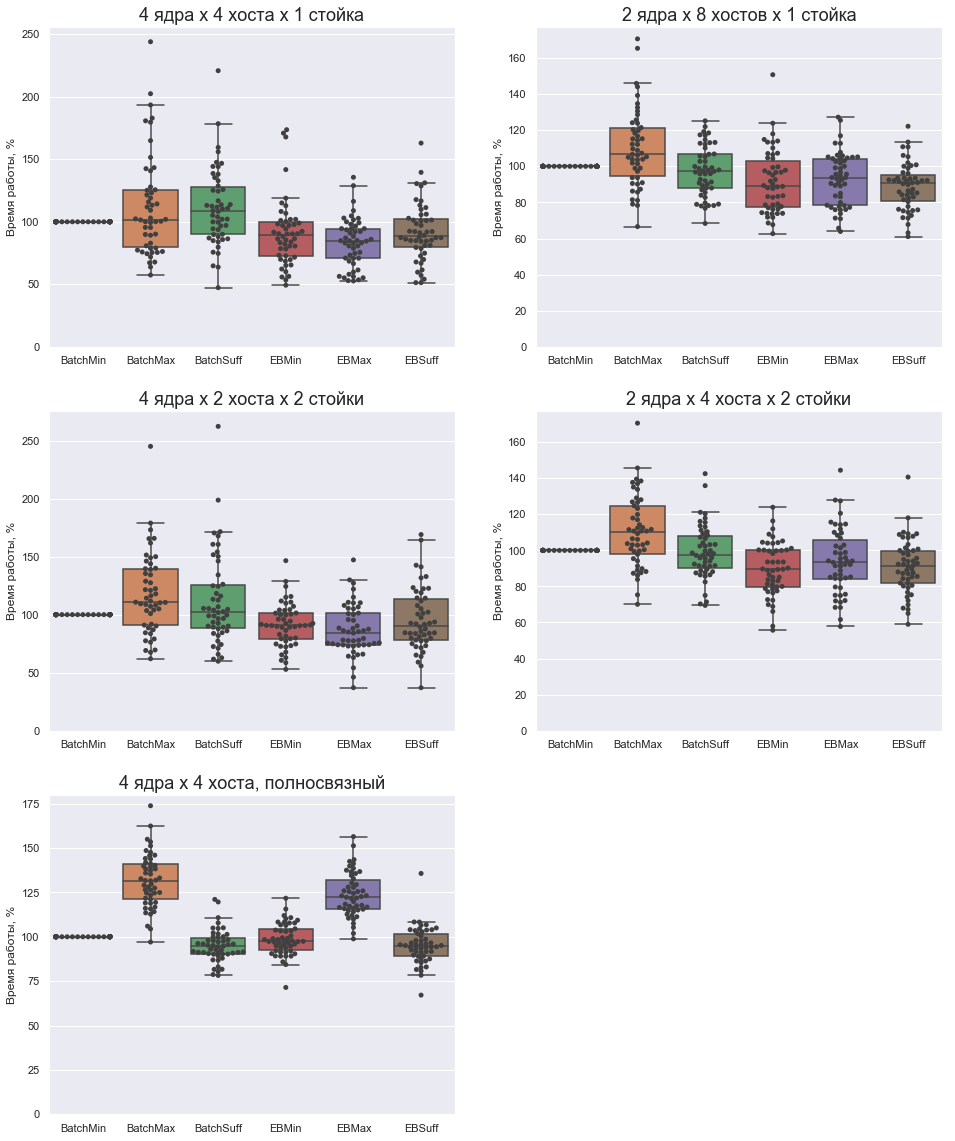

In [5]:
draw_boxplots(show_expected=False)

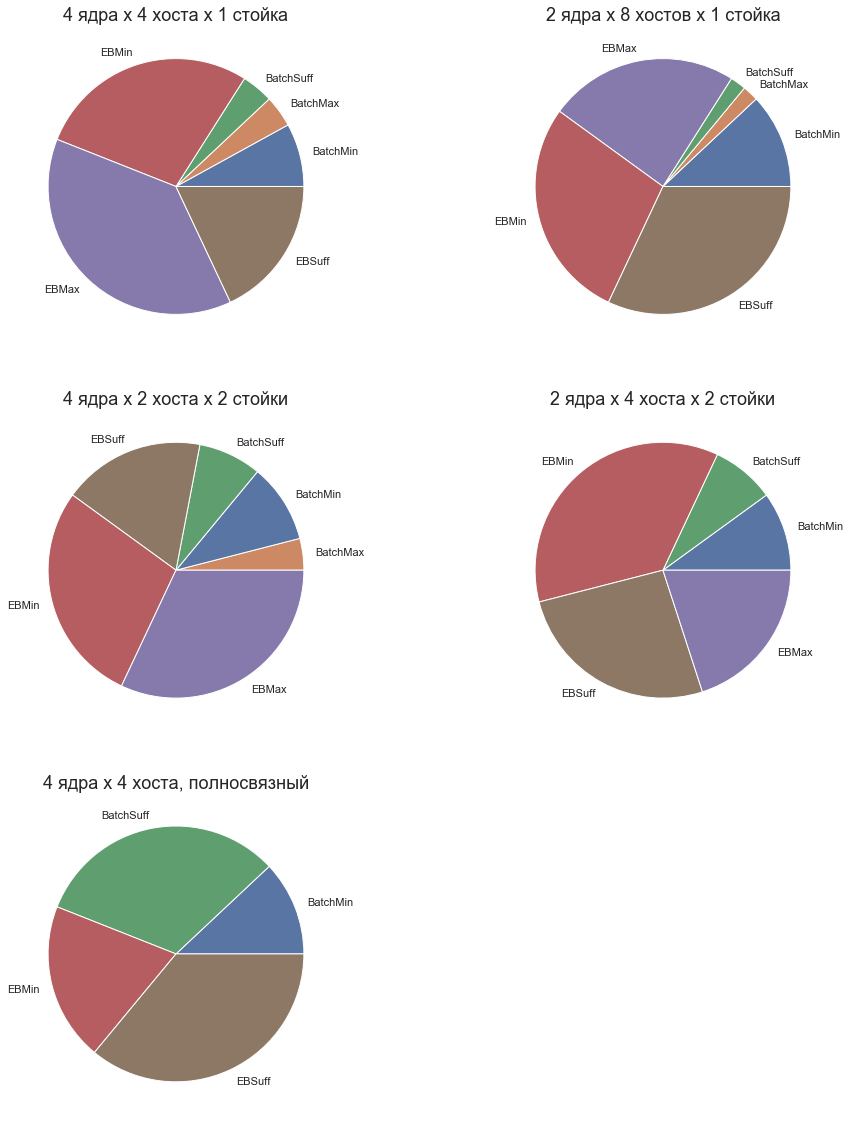

In [6]:
best_by_platform = {}
min_makespans = {}
for r in results:
    best_by_platform.setdefault(r['platform'], {})
    best_by_platform[r['platform']][r['algorithm']['name']] = 0
    min_makespans.setdefault(r['platform'], {})
    min_makespans[r['platform']].setdefault(r['tasks'], [])
    min_makespans[r['platform']][r['tasks']].append((r['makespan'], r['algorithm']['name']))

for platform in min_makespans:
    for wf in min_makespans[platform]:
        best_makespan, best_algorithm = min(min_makespans[platform][wf])
        best_by_platform[platform][best_algorithm] += 1
        
plt.figure(figsize=(16, 20))
for i, (platform, platform_results) in enumerate(sorted(best_by_platform.items(), key=platform_sort_key)):
    plt.subplot((len(best_by_platform)+1)//2, 2, i+1)
    labels, values = zip(*[(k, v) for (k, v) in platform_results.items() if v > 0])
    colors = [algo_colors[x] for x in labels]
    plt.pie(values, labels=labels, colors=colors)
    plt.title(f'{platform_names[platform]}', fontsize=18)